# Example usage of the `torchTextClassifiers` library

*Warning*

*`torchTextClassifiers` library is still under active development. Have a
regular look to <https://github.com/inseefrlab/torchTextClassifiers> for
latest information.*

To install package, you can run the following snippet

In [1]:
from torchTextClassifiers import ModelConfig, TrainingConfig, torchTextClassifiers
from torchTextClassifiers.dataset import TextClassificationDataset
from torchTextClassifiers.model import TextClassificationModel, TextClassificationModule
from torchTextClassifiers.model.components import (
    AttentionConfig,
    CategoricalVariableNet,
    ClassificationHead,
    TextEmbedder,
    TextEmbedderConfig,
)
from torchTextClassifiers.tokenizers import HuggingFaceTokenizer, WordPieceTokenizer
from torchTextClassifiers.utilities.plot_explainability import (
    map_attributions_to_char,
    map_attributions_to_word,
    plot_attributions_at_char,
    plot_attributions_at_word,
)

%load_ext autoreload
%autoreload 2

# Load and preprocess data

In that guide, we propose to illustrate main package functionalities
using that `DataFrame`:

In [2]:
import pandas as pd

df = pd.read_parquet("https://minio.lab.sspcloud.fr/projet-ape/data/08112022_27102024/naf2008/split/df_train.parquet")
df = df.sample(100000)

In [3]:
df

,apet_finale,libelle,CJ,NAT,TYP,SRF,CRT
1390691,6201Z,Le développement et l'exploitation d'un réseau...,5499,99,C,0.0,P
667652,6831Z,Immobilier : agent commercial en immobilier : ...,NaN,NaN,R,0.0,NaN
81199,5320Z,Le point relais est un service qui permet de s...,NaN,NaN,X,0.0,P
609923,7410Z,"CREATION OBJET PERSONNALISE MULTI SUPPORT, act...",NaN,99,M,0.0,P
1494085,1071D,"confection de desserts, pâtisseries artisanale...",NaN,10,M,6.0,P
...,...,...,...,...,...,...,...
775505,7311Z,"Vente de prospect, Marketing publicitaire, Cré...",5499,99,C,0.0,P
394229,9329Z,DJ activité de services,NaN,99,C,0.0,P
149401,6820B,"L'acquisition, l'administration et la gestion ...",6540,99,G,0.0,P
464364,7021Z,"Agence de communication, notamment le conseil ...",5499,99,C,0.0,P


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


def categorize_surface(
    df: pd.DataFrame, surface_feature_name: int, like_sirene_3: bool = True
) -> pd.DataFrame:
    """
    Categorize the surface of the activity.

    Args:
        df (pd.DataFrame): DataFrame to categorize.
        surface_feature_name (str): Name of the surface feature.
        like_sirene_3 (bool): If True, categorize like Sirene 3.

    Returns:
        pd.DataFrame: DataFrame with a new column "surf_cat".
    """
    df_copy = df.copy()
    df_copy[surface_feature_name] = df_copy[surface_feature_name].replace("nan", np.nan)
    df_copy[surface_feature_name] = df_copy[surface_feature_name].astype(float)
    # Check surface feature exists
    if surface_feature_name not in df.columns:
        raise ValueError(f"Surface feature {surface_feature_name} not found in DataFrame.")
    # Check surface feature is a float variable
    if not (pd.api.types.is_float_dtype(df_copy[surface_feature_name])):
        raise ValueError(f"Surface feature {surface_feature_name} must be a float variable.")

    if like_sirene_3:
        # Categorize the surface
        df_copy["surf_cat"] = pd.cut(
            df_copy[surface_feature_name],
            bins=[0, 120, 400, 2500, np.inf],
            labels=["1", "2", "3", "4"],
        ).astype(str)
    else:
        # Log transform the surface
        df_copy["surf_log"] = np.log(df[surface_feature_name])

        # Categorize the surface
        df_copy["surf_cat"] = pd.cut(
            df_copy.surf_log,
            bins=[0, 3, 4, 5, 12],
            labels=["1", "2", "3", "4"],
        ).astype(str)

    df_copy[surface_feature_name] = df_copy["surf_cat"].replace("nan", "0")
    df_copy[surface_feature_name] = df_copy[surface_feature_name].astype(int)
    df_copy = df_copy.drop(columns=["surf_log", "surf_cat"], errors="ignore")
    return df_copy


def clean_and_tokenize_df(
    df,
    categorical_features=["CJ", "NAT", "TYP", "CRT"],
    text_feature="libelle_processed",
    label_col="apet_finale",
):
    df.fillna("nan", inplace=True)
    les = []
    for col in categorical_features:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        les.append(le)

    df = categorize_surface(df, "SRF", like_sirene_3=True)
    df = df[[text_feature,  "CJ", "NAT", "TYP", "SRF", "CRT", label_col]]

    return df, les

In [5]:
categorical_features = [ "CJ", "NAT", "TYP", "SRF", "CRT"]
text_feature = "libelle"
y = "apet_finale"

Right now, the model requires the label (variable y) to be a numerical
variable. If the label variable is a text variable, we recommend using
Scikit Learn’s
[LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
to convert into a numeric variable. Using that function will give user
the possibility to get back labels from the encoder after running
predictions.

In [6]:
encoder = LabelEncoder()
df["apet_finale"] = encoder.fit_transform(df["apet_finale"])

The function `clean_and_tokenize_df` requires special `DataFrame`
formatting:

-   First column contains the processed text (str)
-   Next ones contain the “encoded” categorical (discrete) variables in
    int format

In [7]:
df, _ = clean_and_tokenize_df(df, text_feature="libelle")
X = df[["libelle", "CJ", "NAT", "TYP", "CRT", "SRF"]].values
y = df["apet_finale"].values

In [8]:
X.shape, y.shape

((100000, 6), (100000,))

## Splitting in train-test sets

As usual in a learning approach, you need to break down your data into
learning and test/validation samples to obtain robust performance
statistics.
This work is the responsibility of the package’s users. Please make sure that np.max(y_train) == len(np.unique(y_train))-1 (i.e. your labels are well encoded, in a consecutive manner, starting from 0), and that all the possible labels appear at least once in the training set.

We provide the function stratified_train_test_split to match these requirements here..

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Tokenizer

In [10]:
text = X_train[:, 0].tolist()

In [54]:
tokenizer = HuggingFaceTokenizer.load_from_pretrained("google-bert/bert-base-uncased")
tokenizer.tokenize(text[0]).input_ids.shape

torch.Size([1, 3])

In [55]:
tokenizer.vocab_size

30522

In [ ]:
tokenizer = WordPieceTokenizer(vocab_size=5000, output_dim=125)
tokenizer.train(text)
tokenizer.tokenize(text[:256]).input_ids.shape

torch.Size([256, 125])

## Consider each component indepedently

In [13]:
vocab_size = tokenizer.vocab_size
padding_idx = tokenizer.padding_idx

embedding_dim = 96
n_layers = 1
n_head = 4
n_kv_head = n_head
sequence_len = tokenizer.output_dim

In [14]:
attention_config = AttentionConfig(
    n_layers=n_layers,
    n_head=n_head,
    n_kv_head=n_kv_head,
    sequence_len=sequence_len,
)

text_embedder_config = TextEmbedderConfig(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    padding_idx=padding_idx,
    attention_config=attention_config,
)


text_embedder = TextEmbedder(
    text_embedder_config=text_embedder_config,
)
text_embedder.init_weights()

In [15]:
X[:, 1:].max(axis=0).tolist()

[75, 8, 14, 2, 4]

In [16]:
categorical_vocab_sizes = (X[:, 1:].max(axis=0) + 1).tolist()
categorical_embedding_dims = 25

categorical_var_net = CategoricalVariableNet(
    categorical_vocabulary_sizes=categorical_vocab_sizes,
    categorical_embedding_dims=categorical_embedding_dims,
)

In [17]:
num_classes = int(y.max() + 1)
expected_input_dim = embedding_dim + categorical_var_net.output_dim
classification_head = ClassificationHead(
    input_dim=expected_input_dim,
    num_classes=num_classes,
)

In [18]:
model = TextClassificationModel(
    text_embedder=text_embedder,
    categorical_variable_net=categorical_var_net,
    classification_head=classification_head,
)
model

TextClassificationModel(
  (text_embedder): TextEmbedder(
    (embedding_layer): Embedding(5000, 96, padding_idx=1)
    (transformer): ModuleDict(
      (h): ModuleList(
        (0): Block(
          (attn): SelfAttentionLayer(
            (c_q): Linear(in_features=96, out_features=96, bias=False)
            (c_k): Linear(in_features=96, out_features=96, bias=False)
            (c_v): Linear(in_features=96, out_features=96, bias=False)
            (c_proj): Linear(in_features=96, out_features=96, bias=False)
          )
          (mlp): MLP(
            (c_fc): Linear(in_features=96, out_features=384, bias=False)
            (c_proj): Linear(in_features=384, out_features=96, bias=False)
          )
        )
      )
    )
  )
  (categorical_variable_net): CategoricalVariableNet(
    (categorical_embedding_0): Embedding(76, 25)
    (categorical_embedding_1): Embedding(9, 25)
    (categorical_embedding_2): Embedding(15, 25)
    (categorical_embedding_3): Embedding(3, 25)
    (categorica

In [19]:
import torch

module = TextClassificationModule(
    model=model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    optimizer_params={"lr": 1e-3},
    scheduler=None,
    scheduler_params=None,
    scheduler_interval="epoch",
)
module

TextClassificationModule(
  (model): TextClassificationModel(
    (text_embedder): TextEmbedder(
      (embedding_layer): Embedding(5000, 96, padding_idx=1)
      (transformer): ModuleDict(
        (h): ModuleList(
          (0): Block(
            (attn): SelfAttentionLayer(
              (c_q): Linear(in_features=96, out_features=96, bias=False)
              (c_k): Linear(in_features=96, out_features=96, bias=False)
              (c_v): Linear(in_features=96, out_features=96, bias=False)
              (c_proj): Linear(in_features=96, out_features=96, bias=False)
            )
            (mlp): MLP(
              (c_fc): Linear(in_features=96, out_features=384, bias=False)
              (c_proj): Linear(in_features=384, out_features=96, bias=False)
            )
          )
        )
      )
    )
    (categorical_variable_net): CategoricalVariableNet(
      (categorical_embedding_0): Embedding(76, 25)
      (categorical_embedding_1): Embedding(9, 25)
      (categorical_embedding_2)

## Using the wrapper

In [20]:
model_config = ModelConfig(
    embedding_dim=embedding_dim,
    categorical_vocabulary_sizes=categorical_vocab_sizes,
    categorical_embedding_dims=categorical_embedding_dims,
    num_classes=num_classes,
    attention_config=attention_config,
)

training_config = TrainingConfig(
    lr=1e-3,
    batch_size=256,
    num_epochs=10,
)

ttc = torchTextClassifiers(
    tokenizer=tokenizer,
    model_config=model_config,
)

In [21]:
X_train[1, :]

array(['livraisons a domicile repas et marchandises divers activité de services',
       75, 7, 1, 1, 0], dtype=object)

In [22]:
tokenizer.tokenize(X_train[:256, 0].tolist()).input_ids.shape

torch.Size([256, 125])

In [23]:
ttc.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_test,
    y_val=y_test,
    training_config=training_config,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/onyxia/work/torchTextClassifiers/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                    | Params | Mode 
----------------------------------------------------------------
0 | model       | TextClassificationModel | 664 K  | train
1 | loss        | CrossEntropyLoss        | 0      | train
2 | accuracy_fn | MulticlassAccuracy     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [30]:
X_test[0].shape

(6,)

In [32]:
ttc.pytorch_model.eval().cpu()

TextClassificationModel(
  (text_embedder): TextEmbedder(
    (embedding_layer): Embedding(5000, 96, padding_idx=1)
    (transformer): ModuleDict(
      (h): ModuleList(
        (0): Block(
          (attn): SelfAttentionLayer(
            (c_q): Linear(in_features=96, out_features=96, bias=False)
            (c_k): Linear(in_features=96, out_features=96, bias=False)
            (c_v): Linear(in_features=96, out_features=96, bias=False)
            (c_proj): Linear(in_features=96, out_features=96, bias=False)
          )
          (mlp): MLP(
            (c_fc): Linear(in_features=96, out_features=384, bias=False)
            (c_proj): Linear(in_features=384, out_features=96, bias=False)
          )
        )
      )
    )
  )
  (categorical_variable_net): CategoricalVariableNet(
    (categorical_embedding_0): Embedding(76, 25)
    (categorical_embedding_1): Embedding(9, 25)
    (categorical_embedding_2): Embedding(15, 25)
    (categorical_embedding_3): Embedding(3, 25)
    (categorica

In [46]:
top_k = 5
yyy = ttc.predict(X_test[:10], top_k=top_k, explain=True)

text_idx = 0
text = X_test[text_idx, 0]
offsets = yyy["offset_mapping"][text_idx]  # seq_len, 2
attributions = yyy["attributions"][text_idx]  # top_k, seq_len
word_ids = yyy["word_ids"][text_idx]  # seq_len
predictions = yyy["prediction"][text_idx] 

In [36]:
word_attributions = map_attributions_to_word(attributions, word_ids)
char_attributions = map_attributions_to_char(attributions, offsets, text)


In [52]:
encoder.inverse_transform(np.array([390]))[0]

'5520Z'

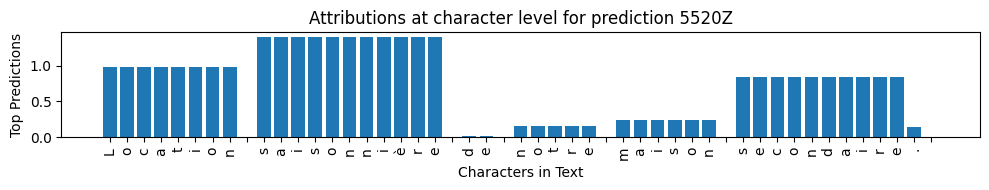

In [53]:
from matplotlib import pyplot as plt
top_k = char_attributions.shape[0]

all_plots = []
for i in range(1):
    plt.figure(figsize=(10, 2))
    plt.bar(range(len(text)), char_attributions[i])
    plt.xticks(ticks=np.arange(len(text)), labels=list(text), rotation=90)
    plt.title(f"Attributions at character level for prediction {encoder.inverse_transform(np.array([predictions[i]]))[0] }")
    plt.xlabel("Characters in Text")
    plt.ylabel("Top Predictions")
    plt.tight_layout()
    all_plots.append(plt)